In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

Importing the dataset

In [5]:
url = 'https://raw.githubusercontent.com/engyssimo/MLProjectNucphys/main/Project2/Data/weatherAUS.csv'
df = pd.read_csv(url)


#Convert date to year, month, day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis = 1, inplace = True)
df.head()

# Need to find again the object variables
object_var = [i for i in df.columns if df[i].dtype=='O']
numerical_var = [i for i in df.columns if df[i].dtype!='O']

## Imputation of the NaN values

In [7]:
# display(df[numerical_var].isnull().sum())
# display(df[object_var].isnull().sum())

for col in numerical_var:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True)

for col in object_var:
    common = df[col].mode()[0]         # returns the most frequent value
    df[col].fillna(common, inplace=True)


display(df[numerical_var].isnull().sum())
display(df[object_var].isnull().sum())    # To check that all missing values are filled in




MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Year             0
Month            0
Day              0
dtype: int64

Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

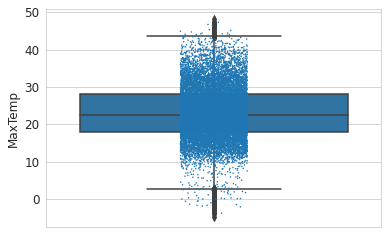

In [8]:
# Boxplot with Seaborn
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))
matplotlib.rcParams.update({'font.size': 12})
ax = sns.boxplot(y='MaxTemp',data=df)
ax = sns.stripplot(y="MaxTemp",data=df.sample(frac=0.1),size=1.5)
plt.savefig("box_plot.png", bbox_inches='tight')

In [14]:
categorical_or_integer_encoding = True #True for categorical, False for integer

# Encoding the variable RainToday -> 1 and 0 representing Rain and No rain (Which is which?)
# Encoding is an addition of variables


def integer_encoding(feature_name):
    ''' 
    This function takes feature name as a parameter and returns mapping dictionary to replace categorical data with numerical data. 
    '''
    mapping = {}
    values = list(df[feature_name].unique())
    for idx in range(len(values)):
        mapping[values[idx]] = idx
    return mapping

#Excluding the outliers

features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for feature in features_with_outliers:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature]<lower_limit,feature] = lower_limit
    df.loc[df[feature]>upper_limit,feature] = upper_limit



#choose encoding
if(categorical_or_integer_encoding):

  #Replace Yes with 1 and No with 0
    df['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
    df['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)
    df.head()
  #Replace the columns with the one-hot encoded variables
    df = pd.concat([df[numerical_var],
                     pd.get_dummies(df.Location),
                     pd.get_dummies(df.WindGustDir,prefix="WindGustDir"),
                     pd.get_dummies(df.WindDir9am,prefix="WindDir9am"),
                     pd.get_dummies(df.WindDir3pm,prefix="WindDir3pm"),
                     df["RainToday"], 
                     df["RainTomorrow"]], axis=1)
    display(df)

else:
  #Here we are doing integer encoding 

  #Replace Yes with 1 and No with 0
    df['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
    df['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)

  #Here we are using the encoding function defined previously 
    df['WindGustDir'].replace(integer_encoding('WindGustDir'), inplace = True)
    df['WindDir9am'].replace(integer_encoding('WindDir9am'), inplace = True)
    df['WindDir3pm'].replace(integer_encoding('WindDir3pm'), inplace = True)
    df['Location'].replace(integer_encoding('Location'), inplace = True)
    df.head()


X = df.drop(["RainTomorrow"], axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday,RainTomorrow
0,13.4,22.9,0.6,4.8,8.4,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,1,0,0,0
1,7.4,25.1,0.0,4.8,8.4,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,1,0,0
2,12.9,25.7,0.0,4.8,8.4,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,4.8,8.4,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,4.8,8.4,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,0.0,4.8,8.4,31.0,13.0,11.0,51.0,24.0,...,0,0,0,0,0,0,0,0,0,0
145456,3.6,25.3,0.0,4.8,8.4,22.0,13.0,9.0,56.0,21.0,...,0,0,0,0,0,0,0,0,0,0
145457,5.4,26.9,0.0,4.8,8.4,37.0,9.0,9.0,53.0,24.0,...,0,0,0,0,0,0,1,0,0,0
145458,7.8,27.0,0.0,4.8,8.4,28.0,13.0,7.0,51.0,24.0,...,0,0,0,0,0,0,0,0,0,0


## Scaling of the data

In [15]:
columns = X_train.columns
#scaler = MinMaxScaler()       # Here we use MinMax scaler, but we could use Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# NOte: when we do the transform, we loose the column and the dataframe, therefore we need to create it again
X_train = pd.DataFrame(X_train, columns = [columns])
X_test = pd.DataFrame(X_test, columns = [columns])

X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday
0,1.038333,0.069783,-0.299833,0.173393,-0.247128,1.013193,1.992888,1.112792,0.267841,1.046686,...,-0.250675,-0.271064,-0.340185,-0.26415,-0.243688,-0.263199,-0.272923,-0.253336,-0.263572,-0.530540
1,-0.454098,0.112250,-0.299833,-1.754514,1.056451,0.684727,-0.110269,0.639069,0.267841,0.166056,...,-0.250675,-0.271064,-0.340185,-0.26415,-0.243688,-0.263199,-0.272923,-0.253336,-0.263572,-0.530540
2,-0.202741,-0.142553,1.670508,-1.754514,0.585714,-1.121842,-1.629217,-0.900532,0.857213,-0.225335,...,-0.250675,-0.271064,-0.340185,-0.26415,-0.243688,3.799404,-0.272923,-0.253336,-0.263572,1.884871
3,1.116882,0.947437,-0.628223,1.550469,1.092661,0.274143,1.408678,-0.189947,-1.339537,-0.714574,...,-0.250675,-0.271064,-0.340185,-0.26415,-0.243688,-0.263199,-0.272923,-0.253336,-0.263572,-0.530540
4,0.551329,-0.793716,1.834703,0.035685,0.151188,-1.614542,-0.343954,-0.663671,1.660902,2.367631,...,-0.250675,-0.271064,-0.340185,-0.26415,-0.243688,-0.263199,-0.272923,-0.253336,-0.263572,1.884871


In [16]:
#Tried with PCA, but performance does not improve

# pca = PCA(n_components=.95)
# pca.fit(X_train)
# X_train = pd.DataFrame(pca.transform(X_train))
# X_test = pd.DataFrame(pca.transform(X_test))
# X_train.head()

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)

classifier.fit(X_train, y_train)
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

y_test_lr = classifier.predict_proba(X_test)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_lr[:,1])

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))

Model accuracy test score:0.8488
Model accuracy train score:0.8484


# DECISION TREE MODEL TRAINING

In [21]:
# No option for max_depth: splitting until leaves contain 1 only element -> This causes heavy overfitting
SimpleTree = DecisionTreeClassifier(random_state=1,max_depth=9)


# Fit of the model
# accuracy = cross_validate(SimpleTree,X_test,y_test,cv=10)['test_score']
# print(accuracy)
# accuracy.mean()
SimpleTree.fit(X_train, y_train)

#ROC
y_test_tree = SimpleTree.predict_proba(X_test)
fpr_tree, tpr_tree, thresholds = roc_curve(y_test, y_test_tree[:,1])


#Predict results

y_pred_test = SimpleTree.predict(X_test)
# y_pred_test
# SimpleTree.predict_proba(X_test)[:,0] # 1 probability of no rain, 0 probability of rain

#We need to check the accuracy score

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
# We need to compare it to the training test score, to check for overfitting or underfitting

y_pred_train = SimpleTree.predict(X_train)

print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))

Model accuracy test score:0.8415
Model accuracy train score:0.8558


Varying max_depth of the single tree

Model accuracy test score:0.8169
Model accuracy train score:0.8156
Model accuracy test score:0.8232
Model accuracy train score:0.8243
Model accuracy test score:0.8299
Model accuracy train score:0.8307
Model accuracy test score:0.8332
Model accuracy train score:0.8350
Model accuracy test score:0.8367
Model accuracy train score:0.8388
Model accuracy test score:0.8381
Model accuracy train score:0.8414
Model accuracy test score:0.8406
Model accuracy train score:0.8461
Model accuracy test score:0.8403
Model accuracy train score:0.8499
Model accuracy test score:0.8415
Model accuracy train score:0.8558
Model accuracy test score:0.8395
Model accuracy train score:0.8638
Model accuracy test score:0.8374
Model accuracy train score:0.8725
Model accuracy test score:0.8347
Model accuracy train score:0.8833
Model accuracy test score:0.8332
Model accuracy train score:0.8946
Model accuracy test score:0.8293
Model accuracy train score:0.9067
Model accuracy test score:0.8246
Model accuracy train score:0.

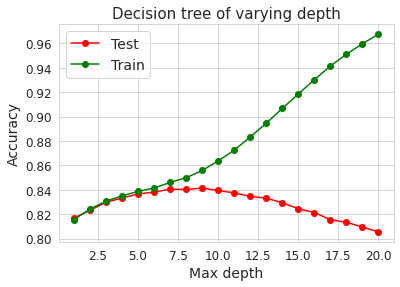

In [20]:
max_max_depth = 20

test_acc = np.zeros(max_max_depth)
train_acc = np.zeros(max_max_depth)

#changing max_depth as the complexity of the tree
for d in range(max_max_depth):
  SimpleTree = DecisionTreeClassifier(max_depth=d+1,random_state=1)
  SimpleTree.fit(X_train, y_train)
  y_pred_test = SimpleTree.predict(X_test)
  test_acc[d] = accuracy_score(y_test,y_pred_test)
  print("Model accuracy test score:{0:0.4f}".format(test_acc[d]))
  y_pred_train = SimpleTree.predict(X_train)
  train_acc[d] = accuracy_score(y_train,y_pred_train)
  print("Model accuracy train score:{0:0.4f}".format(train_acc[d]))

print("Maximum test accuracy: {:.4f} ".format(np.max(test_acc)))
print("For maximum depth: ",np.arange(1,max_max_depth+1)[np.argmax(test_acc)])
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.title("Decision tree of varying depth",fontsize=15)
plt.plot(range(1,max_max_depth+1),test_acc,"o-",color="red",label="Test")
plt.plot(range(1,max_max_depth+1),train_acc,"o-",color="green",label="Train")
plt.xlabel("Max depth",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.legend(fontsize=14)
plt.savefig("Pictures/tree_depth.png", bbox_inches='tight')

# Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier # import the package
from sklearn.tree import DecisionTreeClassifier # import the package

Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1), bootstrap=True, n_jobs=-1, random_state=1,)
#Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=1000, max_samples=200, bootstrap=True, n_jobs=-1, random_state=1)

# Fit of the model

Bag_model.fit(X_train, y_train)

#Predict results
y_pred_test = Bag_model.predict(X_test)
y_pred_test
Bag_model.predict_proba(X_test)[:,0] # 1 probability of no rain, 0 probability of rain

#We need to check the accuracy score
from sklearn.metrics import accuracy_score

print("Model accuracy test score:{0:0.4f}".format(accuracy_score(y_test,y_pred_test)))
# We need to compare it to the training test score, to check for overfitting or underfitting

y_pred_train = Bag_model.predict(X_train)

print("Model accuracy train score:{0:0.4f}".format(accuracy_score(y_train,y_pred_train)))


#
# Adjusting number of trees in the ensemble and fraction of points for the bootstrap
#


n_est = 4
n_fracs = 3

test_acc = np.zeros((n_est,n_fracs))
train_acc = np.zeros((n_est,n_fracs))

max_estimators = 150
max_max_samples = 0.7
i = 0

range_samples = np.arange(0.4,max_max_samples,0.1)

for n_es in range(50 ,max_estimators, 25):
  j = 0
  for sam in range_samples:
    Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=n_es, max_samples=sam, bootstrap=True, n_jobs=-1, random_state=1)
    Bag_model.fit(X_train, y_train)
    y_pred_test = Bag_model.predict(X_test)
    test_acc[i,j] = accuracy_score(y_test,y_pred_test)
    print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,sam,test_acc[i,j]))
    y_pred_train = Bag_model.predict(X_train)
    train_acc[i,j] = accuracy_score(y_train,y_pred_train)
    print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,sam,train_acc[i,j]))
    j+=1
  plt.figure(figsize=(5,4))
  plt.title("n_estimators = {}".format(n_es))
  plt.plot(range_samples,test_acc[i],label="test")
  plt.plot(range_samples,train_acc[i],label="train")
  plt.xlabel("Max depth")
  plt.legend()
  plt.show()
  i+=1




In [ ]:
#@title
from sklearn.ensemble import BaggingClassifier # import the package
from sklearn.tree import DecisionTreeClassifier # import the package

#best parameters
n_es = 100
max_samples = 0.4

#
# Adjusting max depth of the individual decision trees
#


range_depth = np.arange(5,10,1)

n_fracs = len(range_depth)
test_acc = np.zeros(n_fracs)
train_acc = np.zeros(n_fracs)

j = 0

for d in range_depth:
  Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1,max_depth=d),n_estimators=n_es, max_samples=max_samples, bootstrap=True, n_jobs=-1, random_state=1)
  Bag_model.fit(X_train, y_train)
  y_pred_test = Bag_model.predict(X_test)
  test_acc[j] = accuracy_score(y_test,y_pred_test)
  # print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,max_samples,test_acc[j]))
  print("Max_depth: {0}, Model accuracy test score:{1:0.4}".format(d,test_acc[j]))
  y_pred_train = Bag_model.predict(X_train)
  train_acc[j] = accuracy_score(y_train,y_pred_train)
  # print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,max_samples,train_acc[j]))
  print("Max_depth: {0}, Model accuracy train score:{1:0.4}".format(d,train_acc[j]))
  j+=1
plt.figure(figsize=(5,4))
plt.title("n_estimators = {}".format(n_es))
plt.plot(range_depth,test_acc,label="test")
plt.plot(range_depth,train_acc,label="train")
plt.xlabel("Max depth")
plt.legend()
plt.show()

Best parameters are selected:

*   n_es = 100
*   max_samples = 0.4
*   Decision tree with default depth (splits until leaf is pure)

Now we compare the results for the test set with the null accuracy


In [ ]:
#Best parameters
n_es = 100
max_samples = 0.4

Bag_model = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=n_es, max_samples=max_samples, bootstrap=True, n_jobs=-1, random_state=1)
Bag_model.fit(X_train, y_train)
y_pred_test = Bag_model.predict(X_test)
test_acc = accuracy_score(y_test,y_pred_test)
print("Model accuracy test score:{0:0.4}".format(test_acc))
y_pred_train = Bag_model.predict(X_train)
train_acc = accuracy_score(y_train,y_pred_train)
print("Model accuracy train score:{0:0.4}".format(train_acc))

#ROC
y_test_bag = Bag_model.predict_proba(X_test)
fpr_bag, tpr_bag, thresholds = roc_curve(y_test, y_test_bag[:,1])


#null accuracy
null_accuracy = y_test.value_counts()[0]/( y_test.value_counts()[0]+ y_test.value_counts()[1])
print("The null accuracy is {:0.4f} ".format(null_accuracy))

Model accuracy test score:0.8556
Model accuracy train score:0.9446
The null accuracy is 0.7812 


## Confusion Matrix

In this section, we will use the tool of the confusion matrix to study the performance of our model.

There are 4 different type of outcomes when evaluating the model performance:

- True positives (TP): We predict that it rains, and it rains
- True negative (TN): We predict that it does not rain, and it does not
- False positive (FP): We predict that it rains, and it does not -> Type I error
- False negative (FN): We predict that it doesnt rain, and it does -> Type II error



Confusion matrix

 [[21691  1035]
 [ 3167  3199]]
Classification accuracy: 0.8556
Classification error: 0.1444
Precision: 0.9545
Recall: 0.8726


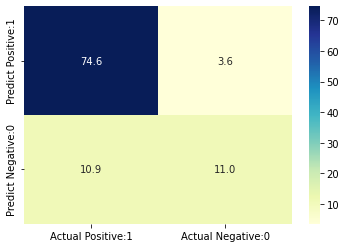

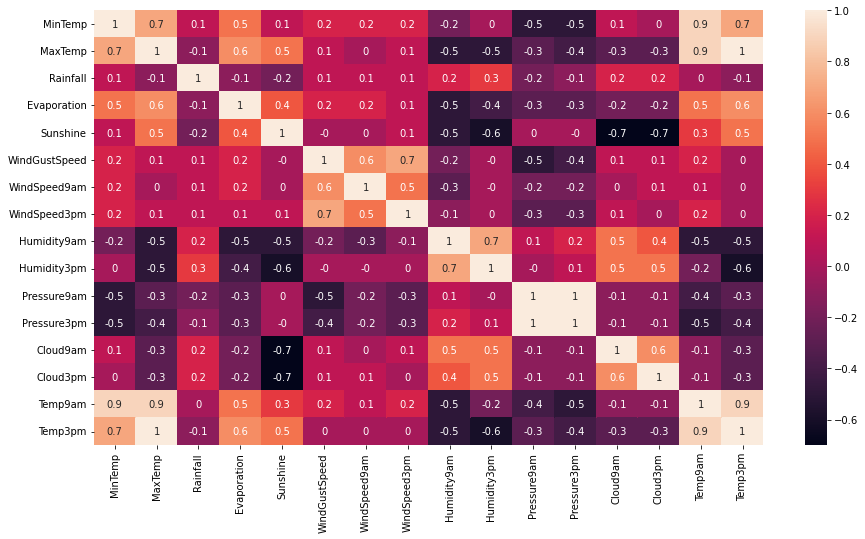

In [ ]:
cm = confusion_matrix(y_test,y_pred_test)
print('Confusion matrix\n\n', cm)

# print('\nTrue Positives(TP) = ', cm[0,0])

# print('\nTrue Negatives(TN) = ', cm[1,1])

# print('\nFalse Positives(FP) = ', cm[0,1])

# print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_percent = cm/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])*100
cm

plt.figure(figsize=(6,4))
cm_matrix = pd.DataFrame(data=cm_percent, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',fmt='.1f')
## Classification

#Ways of evaluating model performance
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
# Classification accuracy: 
# Sum of the true positive and true negative / total
print("Classification accuracy: {:.4f}".format((TP+TN)/float(TP+TN+FP+FN)))

# Classification error: incorrectly classified
print("Classification error: {:.4f}".format((FP+FN)/float(TP+TN+FP+FN)))
# Precision: Percentage of correctly predicted positive outcomes out of all predicted positive outcomes
print("Precision: {:.4f}".format((TP)/float(TP+FP)))

# Recall: Ration of all correctly predicted positive outcomes to all actual positive outcomes
print("Recall: {:.4f}".format((TP)/float(TP+FN)))
# Correlation matrix

df_original = pd.read_csv(url)
correlation_matrix = df_original.corr().round(1)
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

# Random Forest

Best estimated parameters:
* n_estimators = 1200
* max_sample = 0.75



In [18]:
n_es = 800
sam = 0.75

Random_Forest_model = RandomForestClassifier(n_estimators=n_es, random_state=1,max_features="auto",max_samples=sam,min_samples_split=2,min_samples_leaf=5)
# Random_Forest_model.fit(X_train, y_train)
# y_pred_test = Random_Forest_model.predict(X_test)
# y_pred_train = Random_Forest_model.predict(X_train)
# test_acc = accuracy_score(y_test,y_pred_test)
# train_acc = accuracy_score(y_train,y_pred_train)
# print("n_es:{0}, sam:{1}, Model accuracy test score:{2:0.4f}".format(n_es,sam,test_acc))
# print("n_es:{0}, sam:{1}, Model accuracy train score:{2:0.4f}".format(n_es,sam,train_acc))


#Cross validation
Random_Forest_model.fit(X_train, y_train)
accuracy = cross_validate(Random_Forest_model,X_test,y_test,cv=5)['test_score']

print(accuracy)
print(accuracy.mean())

print("Test set accuracy with Random Forests and scaled data: {:.4f}".format(Random_Forest_model.score(X_test,y_test)))


y_test_rf = Random_Forest_model.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_rf[:,1])


[0.8461935  0.84206908 0.84805775 0.84633895 0.84926091]
0.8463840404747998
Test set accuracy with Random Forests and scaled data: 0.8526


In [ ]:
print("Train set accuracy with Random Forests and scaled data: {:.4f}".format(Random_Forest_model.score(X_train,y_train)))

Train set accuracy with Random Forests and scaled data: 0.8969


## GRADIENT BOOSTING

In [7]:
XGB_clf = xgb.XGBClassifier(max_depth=5,n_estimators=500)
XGB_clf.fit(X_train, y_train)
y_pred_test = XGB_clf.predict(X_test)
y_pred_train = XGB_clf.predict(X_train)
test_acc = accuracy_score(y_test,y_pred_test)
train_acc = accuracy_score(y_train,y_pred_train)
print("Model accuracy test score:{0:0.4f}".format(test_acc))
print("Model accuracy train score:{0:0.4f}".format(train_acc))

y_test_xgb = XGB_clf.predict_proba(X_test)
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_test_xgb[:,1])


Model accuracy test score:0.8611
Model accuracy train score:0.8863


Confusion matrix

 [[21572  1154]
 [ 2887  3479]]


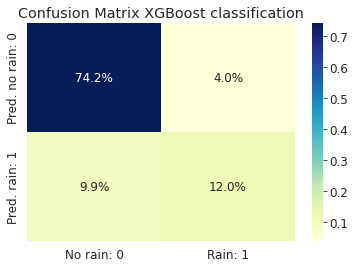

In [8]:
cm = confusion_matrix(y_test,y_pred_test)
print('Confusion matrix\n\n', cm)

# visualize confusion matrix with seaborn heatmap
cm_percent = cm/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
cm

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.title("Confusion Matrix XGBoost classification")
cm_matrix = pd.DataFrame(data=cm_percent, columns=['No rain: 0','Rain: 1'], 
                                 index=[ 'Pred. no rain: 0','Pred. rain: 1'])
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',fmt='.1%')

plt.savefig("cm_xgb.png",bbox_inches="tight")

### ROC Curve

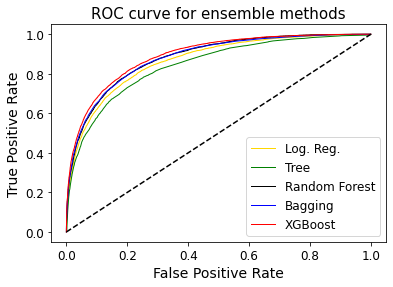

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,4))
plt.plot(fpr_lr,tpr_lr,'-',color="gold",linewidth=1,label="Log. Reg.")
plt.plot(fpr_tree,tpr_tree,'-g',linewidth=1,label="Tree")
plt.plot(fpr_rf,tpr_rf,"-",color="black",linewidth=1,label="Random Forest")
plt.plot(fpr_bag,tpr_bag,'-b',linewidth=1,label="Bagging")
plt.plot(fpr_xgb,tpr_xgb,'-r',linewidth=1,label="XGBoost")
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC curve for ensemble methods',fontsize=15)
plt.xlabel("False Positive Rate",fontsize=14)
plt.ylabel("True Positive Rate",fontsize=14)
plt.legend()
plt.savefig("ROC_ensemble.png",bbox_inches="tight")